## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import nannyml as nml
from test_harness.datasets.dataset import Dataset

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment

## Load Data

In [4]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

In [5]:
change_points

[0, 123785, 247570, 371355]

## Experiments

### Prepare Test Harness

In [6]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

In [7]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2, change_points=change_points, reference_size=1000,
)

d:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.reference_df['period'] = 'reference'
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.reference_df['sample_num'] = self.reference_df.index
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [8]:
CT_dataset.analysis_df

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type,period,sample_num
1000,0.552461,0.119444,0.348485,0.349320,0.329457,0.644232,0.854331,0.724409,0.358268,0.550118,1.0,0.0,0.0,0.0,0.0,analysis,1000
1001,0.441062,0.536111,0.272727,0.365068,0.335917,0.191794,0.846457,0.988189,0.645669,0.101771,0.0,0.0,1.0,0.0,1.0,analysis,1001
1002,0.698834,0.250000,0.181818,0.193271,0.271318,0.024589,0.940945,0.866142,0.000000,0.231981,0.0,1.0,0.0,0.0,0.0,analysis,1002
1003,0.550518,0.300000,0.469697,0.344309,0.436693,0.152311,1.000000,0.740157,0.149606,0.084065,1.0,0.0,0.0,0.0,1.0,analysis,1003
1004,0.627591,0.916667,0.121212,0.107373,0.237726,0.137277,0.795276,0.909449,0.661417,0.243831,0.0,1.0,0.0,0.0,0.0,analysis,1004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495136,0.065523,0.948819,0.736220,0.376985,0.763780,0.531736,0.266150,0.777778,0.136364,0.107373,0.0,1.0,0.0,0.0,1.0,analysis,495136
495137,0.121428,0.988189,0.791339,0.439652,0.732283,0.587435,0.248062,0.677778,0.242424,0.085898,0.0,1.0,0.0,0.0,1.0,analysis,495137
495138,0.062178,0.874016,0.594488,0.706758,0.818898,0.646373,0.298450,0.011111,0.136364,0.202577,0.0,0.0,0.0,1.0,1.0,analysis,495138
495139,0.370277,0.866142,0.433071,0.509344,0.937008,0.516192,0.227390,0.244444,0.181818,0.021475,0.0,0.0,0.0,1.0,1.0,analysis,495139


In [9]:
max_comp_num = drift_df.shape[1]

#### EDA on dataset

In [10]:
#CT_dataset.full_df.corr().to_csv('full_correlation.csv')

In [11]:
# plt.figure(figsize=(12,10))
# sns.heatmap(CT_dataset.full_df.corr(), annot=True)
#
# plt.title('Original dataset correlation map')
# #plt.show()

## Run Experiments

In [12]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [13]:
def plot_windowed_correlation(corr_dict, vertical_lines):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    #labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [14]:
corr_dict = windowed_correlation(CT_dataset.full_df.loc[:, CT_dataset.full_df.columns[:5]], mode='expanding')

In [15]:
#plot_windowed_correlation(corr_dict, change_points)

In [16]:
column_names = list(CT_dataset.reference_df.columns[:3])

In [18]:
drift_detector = 'wasserstein'

In [19]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num',
    continuous_methods=[drift_detector],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=1000,
)

calc.fit(CT_dataset.reference_df)

d:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\nannyml\chunk.py:181: UserWarning: The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.
  warnings.warn(
d:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\nannyml\chunk.py:181: UserWarning: The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.
  warnings.warn(
d:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\nannyml\chunk.py:181: UserWarning: The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.
  warnings.warn(


In [20]:
results = calc.calculate(CT_dataset.analysis_df)

d:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\nannyml\drift\univariate\result.py:74: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  data = pd.concat([self.data.loc[:, (['chunk'])], self.data.loc[:, (column_names, methods)]], axis=1)


In [21]:
change_points

[0, 123785, 247570, 371355]

In [22]:
results_js = results.filter(column_names=results.continuous_column_names, methods=[drift_detector]).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]
display(results_js)

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,elevation_wasserstein_value,elevation_wasserstein_upper_threshold,elevation_wasserstein_lower_threshold,elevation_wasserstein_alert,aspect_wasserstein_value,aspect_wasserstein_upper_threshold,aspect_wasserstein_lower_threshold,aspect_wasserstein_alert,slope_wasserstein_value,slope_wasserstein_upper_threshold,slope_wasserstein_lower_threshold,slope_wasserstein_alert
0,[0:999],0,0,999,None,None,analysis,0.007167,0.0,0,True,0.011865,0.0,0,True,0.007929,0.0,0,True
1,[1000:1999],1,1000,1999,None,None,analysis,0.007076,0.0,0,True,0.030113,0.0,0,True,0.004835,0.0,0,True
2,[2000:2999],2,2000,2999,None,None,analysis,0.006495,0.0,0,True,0.011292,0.0,0,True,0.005146,0.0,0,True
3,[3000:3999],3,3000,3999,None,None,analysis,0.008802,0.0,0,True,0.027366,0.0,0,True,0.003145,0.0,0,True
4,[4000:4999],4,4000,4999,None,None,analysis,0.010609,0.0,0,True,0.035293,0.0,0,True,0.004676,0.0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,[489000:489999],489,489000,489999,None,None,analysis,0.270806,0.0,0,True,0.474602,0.0,0,True,0.367440,0.0,0,True
490,[490000:490999],490,490000,490999,None,None,analysis,0.265766,0.0,0,True,0.473566,0.0,0,True,0.369112,0.0,0,True
491,[491000:491999],491,491000,491999,None,None,analysis,0.281809,0.0,0,True,0.467751,0.0,0,True,0.357361,0.0,0,True
492,[492000:492999],492,492000,492999,None,None,analysis,0.274441,0.0,0,True,0.470751,0.0,0,True,0.354240,0.0,0,True


In [23]:
results_js.columns

Index(['chunk_chunk_key', 'chunk_chunk_chunk_index', 'chunk_chunk_start_index',
       'chunk_chunk_end_index', 'chunk_chunk_start_date',
       'chunk_chunk_end_date', 'chunk_chunk_period',
       'elevation_wasserstein_value', 'elevation_wasserstein_upper_threshold',
       'elevation_wasserstein_lower_threshold', 'elevation_wasserstein_alert',
       'aspect_wasserstein_value', 'aspect_wasserstein_upper_threshold',
       'aspect_wasserstein_lower_threshold', 'aspect_wasserstein_alert',
       'slope_wasserstein_value', 'slope_wasserstein_upper_threshold',
       'slope_wasserstein_lower_threshold', 'slope_wasserstein_alert'],
      dtype='object')

<AxesSubplot:>

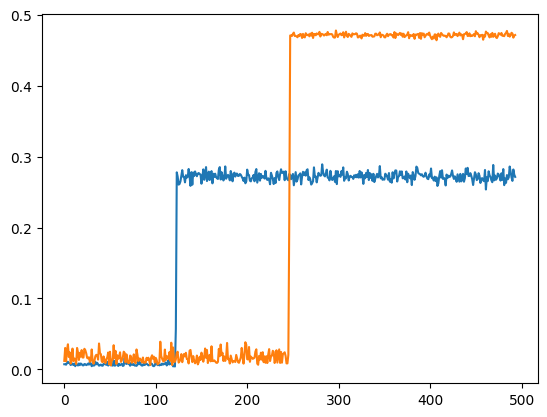

In [24]:
results_js[[col for col in results_js.columns if f'_{drift_detector}_value' in col]].iloc[:, :-1].plot(legend=False)

In [25]:
#figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
#figure.show()

In [26]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### Own Jensen-Shannon

In [27]:
dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=1000, radius_right=1000)
display(dde_exp_eq_radius.results_all)

122785 123785 124785
246570 247570 248570
370355 371355 372355


d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['period'] = 'reference'
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['sample_num'] = ref_df.index
d:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,start,change_point,end,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type,sample_num
0,122785,123785,124785,0.677523,0.044935,0.127194,0.354763,0.052703,0.575389,0.058876,0.080126,0.091013,0.281122,0.015273,0.003494,0.017127,0.024410,0.002565,0.99801
1,246570,247570,248570,0.082540,0.738349,0.995522,0.090822,0.975469,0.104845,0.974967,0.714436,0.844548,0.080445,0.003394,0.012981,0.001707,0.005743,0.013717,0.99801
2,370355,371355,372355,0.102926,0.090526,0.071732,0.080801,0.070375,0.079738,0.076800,0.054189,0.122517,0.092047,0.541940,0.365868,0.365998,0.542663,0.006838,0.99801


In [28]:
dde_exp_eq_radius.changepoint_radius_corr(radius_left=1000, radius_right=1000)

122785 123785 124785
246570 247570 248570
370355 371355 372355


#### Change point 1

In [29]:
dde_exp_eq_radius.corr_scores[123785]['reference']

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type
elevation,1.000000,0.113262,-0.107275,0.254587,0.107896,0.225160,-0.019738,0.178264,0.121398,-0.005812,-0.074194,0.293780,-0.051586,-0.167524,-0.472416
aspect,0.113262,1.000000,0.040930,0.048018,0.085706,0.093875,-0.553944,0.421426,0.634532,-0.075016,-0.119261,0.079559,0.077403,0.031304,-0.023925
slope,-0.107275,0.040930,1.000000,0.038552,0.287666,-0.150567,-0.251319,-0.424437,-0.172299,-0.093417,-0.211997,-0.014114,0.216616,0.033690,0.085259
horizontal_dist_to_hydrology,0.254587,0.048018,0.038552,1.000000,0.575408,0.059654,-0.069723,0.084322,0.092072,0.053977,-0.142245,0.058207,0.120530,-0.054809,0.117451
vertical_dist_to_hydrology,0.107896,0.085706,0.287666,0.575408,1.000000,0.036474,-0.165036,-0.005153,0.078069,-0.003627,-0.165061,-0.019340,0.176895,-0.011255,0.116418
horizontal_dist_to_roadways,0.225160,0.093875,-0.150567,0.059654,0.036474,1.000000,-0.025418,0.172900,0.126158,0.273383,0.446747,-0.245640,-0.321413,-0.065821,-0.050993
hillshade_9am,-0.019738,-0.553944,-0.251319,-0.069723,-0.165036,-0.025418,1.000000,-0.143877,-0.823842,0.088692,0.181174,0.005351,-0.179672,-0.048279,0.038866
hillshade_noon,0.178264,0.421426,-0.424437,0.084322,-0.005153,0.172900,-0.143877,1.000000,0.657501,0.025591,-0.019655,0.043954,-0.001595,-0.002464,0.020962
hillshade_3pm,0.121398,0.634532,-0.172299,0.092072,0.078069,0.126158,-0.823842,0.657501,1.000000,-0.042049,-0.120490,0.020313,0.107467,0.034523,-0.037835
horizontal_dist_to_fire_points,-0.005812,-0.075016,-0.093417,0.053977,-0.003627,0.273383,0.088692,0.025591,-0.042049,1.000000,0.328827,0.057957,-0.353730,-0.052481,0.021979


In [30]:
CT_dataset.change_points

[123785, 247570, 371355]

In [71]:
with pd.ExcelWriter(f'measurements/final/monitored/covertype/monitored_KS.xlsx') as writer:

    for chp in CT_dataset.change_points[:1]:
        drift_threshold = 0.05
        summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'ref_corr', 'analysis_corr', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

        corr_df_delta = dde_exp_eq_radius.corr_scores[chp]['corr_delta']
        corr_df_analysis = dde_exp_eq_radius.corr_scores[chp]['analysis']
        corr_df_ref = dde_exp_eq_radius.corr_scores[chp]['reference']

        cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

        for pair in itertools.combinations(dde_exp_eq_radius.dataset.full_df.columns, 2):
            feat1 = list(pair)[0]
            feat2 = list(pair)[1]

            summary_df.loc[len(summary_df.index)] = [feat1, feat2, np.abs(corr_df_ref.loc[feat1, feat2]), np.abs(corr_df_analysis.loc[feat1, feat2]), corr_df_delta.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

        summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)

        summary_df.to_excel(writer, sheet_name=f'{chp}', index=False)

In [72]:
summary_df = summary_df.sort_values(by=['corr_delta'], ascending=False)

In [73]:
summary_df

,feat_1,feat_2,ref_corr,analysis_corr,corr_delta,feat_1_cd_score,feat_2_cd_score,delta_cd_score,feat_1_drift,feat_2_drift,feat_pair_drift
39,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,0.575408,0.053563,0.628971,0.354763,0.052703,0.302061,1,1,1
54,vertical_dist_to_hydrology,horizontal_dist_to_fire_points,0.003627,0.624730,0.628357,0.052703,0.281122,0.228420,1,1,1
13,elevation,cover_type,0.472416,0.115045,0.587461,0.677523,0.002565,0.674957,1,0,0
45,horizontal_dist_to_hydrology,wilderness_area_1,0.142245,0.437954,0.580199,0.354763,0.015273,0.339491,1,0,0
64,horizontal_dist_to_roadways,wilderness_area_1,0.446747,0.102129,0.548876,0.575389,0.015273,0.560116,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
51,vertical_dist_to_hydrology,hillshade_9am,0.165036,0.169009,0.003972,0.052703,0.058876,0.006173,1,1,1
81,hillshade_noon,wilderness_area_3,0.001595,0.001993,0.003588,0.080126,0.017127,0.063000,1,0,0
62,horizontal_dist_to_roadways,hillshade_3pm,0.126158,0.122959,0.003199,0.575389,0.091013,0.484376,1,1,1
36,slope,wilderness_area_3,0.216616,0.214582,0.002033,0.127194,0.017127,0.110068,1,0,0


In [74]:
summary_df.feat_pair_drift.sum()

36

In [75]:
def get_roc_auc(scores, ys):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [76]:
def plot_lift_curve(y_pred, y_val, step=0.01):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) # The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [77]:
score = summary_df.ref_corr #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

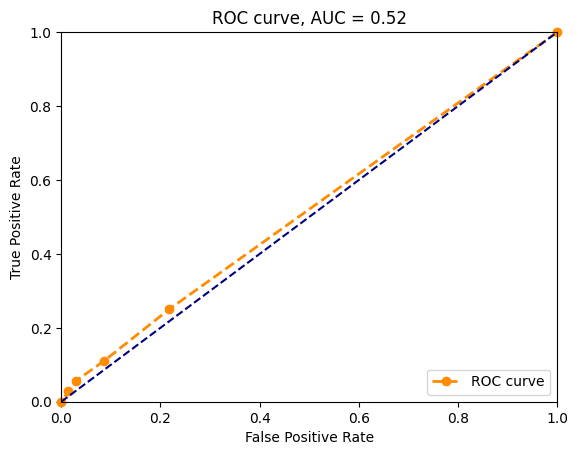

In [78]:
get_roc_auc(score, y)

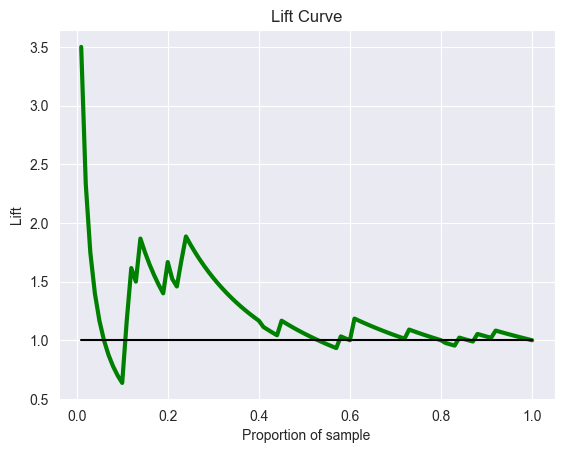

In [38]:
plot_lift_curve(score, y)